In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display
import time
import cvxpy as cp
from scipy.optimize import minimize 

In [21]:
class CartPoleSystem:

    def __init__(self):
        '''Cart-pole parameters'''
        self.gravity   = -9.81
        self.masscart  = 1.0
        self.masspole  = 0.5
        self.length    = 0.5
        self.drag = 0

    def ode(self, x, u):
        '''Continous time dynamics'''
        m = self.masspole
        M = self.masscart
        L = self.length
        d = self.drag
        g = self.gravity
        
        Sx = np.sin(x[2])
        Cx = np.cos(x[2])
        D = m*L*L*(M+m*(1-Cx**2))
        
        dx = np.zeros(4)

        dx[0] = x[1]
        dx[1] = (1/D)*((-(m**2)*(L**2)*g*Cx*Sx + m*(L**2)*(m*L*(x[3]**2)*Sx - d*x[1])) + m*L*L*u)
        dx[2] = x[3]
        dx[3] = (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*(x[3]**2)*Sx - d*x[1]) + m*L*Cx*u)

        return dx
    
    def euler(self, state, control, dt):
        '''Euler-integrator'''
        return state + dt * self.ode(state, control)
    
    def rk4(self, state, control, dt):
        '''Runge-Kuta integrator'''
        k1 = dt * self.ode(state, control)
        k2 = dt * self.ode(state + k1 / 2, control)
        k3 = dt * self.ode(state + k2 / 2, control)
        k4 = dt * self.ode(state + k3, control)
        return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

In [3]:
def plot_traj(state_sequence): 
    """Input a N*4*1 matrix, will prinit trajectory as an animation"""
    N = len(state_sequence)

    for i in range(N):
        # pole
        plt.scatter(state_sequence[i,0]+CartPoleSystem().length*np.sin(state_sequence[i,2]),-CartPoleSystem().length*np.cos(state_sequence[i,2]),marker='o',label = 'upper_mass')
        # cart
        plt.scatter(state_sequence[i,0],0,marker='o', s = 50,label = 'cart')
        
        plt.grid()
        plt.legend()

        num = int(state_sequence[i,0]/5)

        plt.xlim([5*(num-1), 5*(num+1)])
        plt.ylim([-5, 5])
        
        IPython.display.clear_output(wait=True)
        display(plt.gcf())
        time.sleep(0.01)
        plt.clf()  # Clear the current figure

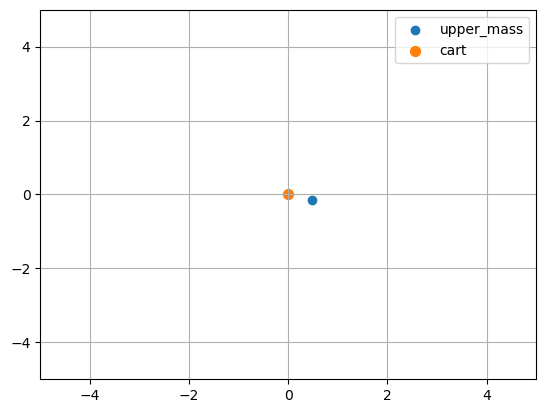

<Figure size 640x480 with 0 Axes>

In [4]:
car = CartPoleSystem()

#generate random u, u \in R^1
N = 50 #steps
u = np.zeros(N)
dt = 0.1

# initial state, change the angle here and see the result when control input is 0
x0 = np.array([0,0,np.deg2rad(90)+0.1,0]) 

state = np.zeros((N+1,4))
state[0] = x0
for i in range(N):
    state[i+1] = car.rk4(state[i],u[i],dt)

plot_traj(state)

## MPC


In [24]:
def cost_scipy(us, bot, initial_state, Q, R, E, goal, MPC_horizon, dt):
    '''cost function for MPC problem'''
    n = 4 #state dimention
    m = 1 #control dimention
    
    xs = np.zeros((MPC_horizon+1,n))
    xs[0] = initial_state
    # initial state is a parameter. It can be updated before solving the problem
    
    objective = 0
    
    for t in range(MPC_horizon):
        objective += np.maximum(np.abs(xs[t][0]-5),0) * E
        objective += np.sum(((xs[t]-goal)**2)@Q) + (us[t]**2)*R

        xs[t+1] = bot.rk4(xs[t],us[t],dt)
    objective += np.sum(((xs[t]-goal)**2)@Q)

    return objective

In [43]:
dt = 0.01
n = 4 #state_dimention
m = 1 #control_dimention

N_MPC_horizon = 5
N_total_horizon = 20

cart = CartPoleSystem()

Q = np.diag([0.1, 0.1, 1000000., 1000.]) 
R = np.diag([0.1])
E = 0

MPC_states = np.zeros((N_total_horizon+1,n))   # size [time_horizon+1, n]
MPC_controls = np.zeros((N_total_horizon+1,m)) # size [time_horizon, m]

initial_state = np.array([0,0,0,0])
goal_state = np.array([1,0,np.pi,0])

k = 0
MPC_states[0] = initial_state 
while k < N_total_horizon:
    
    result = minimize(cost_scipy, args=(CartPoleSystem(), MPC_states[k], Q, R, E, goal_state, N_MPC_horizon, dt),
                  x0=np.zeros(N_MPC_horizon), method='SLSQP')

    MPC_controls[k] = result.x[0]
    MPC_states[k+1] = cart.rk4(MPC_states[k],MPC_controls[k],dt)
    k += 1

# print(MPC_states)
# print(MPC_controls)

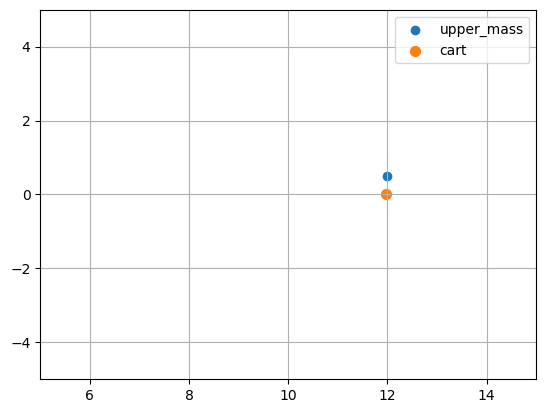

<Figure size 640x480 with 0 Axes>

In [44]:
plot_traj(MPC_states)

Text(0.5, 0, 't')

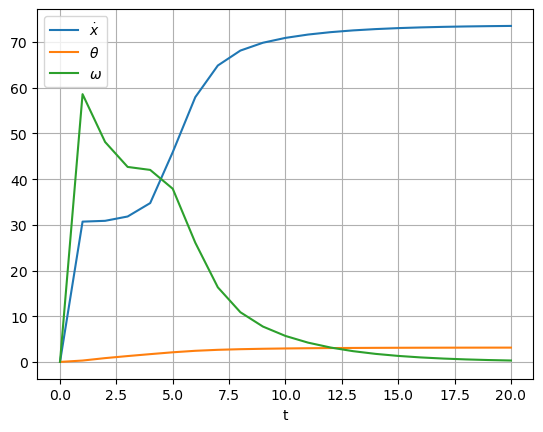

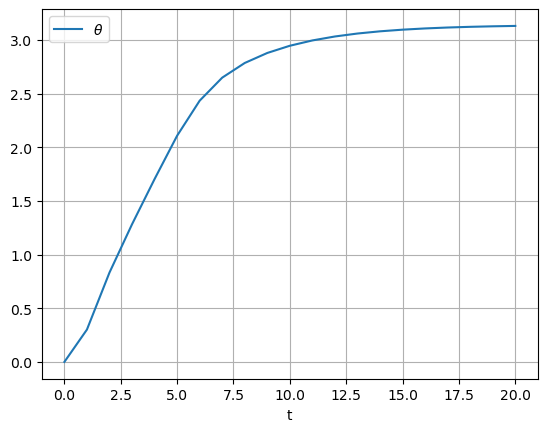

In [42]:
plt.figure()
# plt.plot(MPC_controls[:])
plt.plot(MPC_states[:,1],label = r'$\dot{x}$')
plt.plot(MPC_states[:,2],label = r'$\theta$')
plt.plot(MPC_states[:,3],label = r'$\omega$')
plt.grid()
plt.legend()
plt.xlabel('t')


plt.figure()
plt.plot(MPC_states[:,2],label = r'$\theta$')
plt.grid()
plt.legend()
plt.xlabel('t')